In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


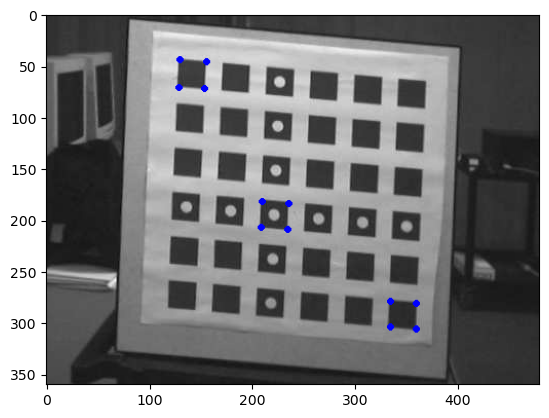

In [3]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [4]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))	

top_left_x = np.array([0, 160, 400])
top_left_y = np.array([0, 240, 400])

# bias for 4 corners: top_left -> top_right -> bottom_left -> bottom_right
bias_x = np.array([0, 50, 50, 0])
bias_y = np.array([0, 0, 50, 50])

# broadcasting to compute 3D coordinates
front_3Dcoord[:, 0] = (top_left_x[:, None] + bias_x).flatten()
front_3Dcoord[:, 1] = (top_left_y[:, None] + bias_y).flatten()
front_3Dcoord[:, 2] = 0	# just set z coordinate to 0

back_3Dcoord = front_3Dcoord.copy()
back_3Dcoord[:, 2] = 150	# just change z coordinate

all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)

(24, 2) (24, 3)


In [5]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# 	   [ P_1^T 		0^T		-x_1*P_1^T ]
#      [ 0^T 		P_1^T	-y_1*P_1^T ]
# P =    		... 	...			
# 	  [ P_n^T 		0^T		-x_n*P_n^T ]
# 	  [ 0^T 		P_n^T	-y_n*P_n^T ]
#
# ------------TODO----------------

P = np.zeros((48, 12))

homo_3D = np.concatenate((all_3Dcoord, np.ones((all_3Dcoord.shape[0], 1))), axis=1)
P[::2, :4] = homo_3D	# ndarray slice: [start:stop:step]
P[1::2, 4:8] = homo_3D

all_2Dcoord_x, all_2Dcoord_y = all_2Dcoord[:, 0], all_2Dcoord[:, 1]

P[::2, 8:] = - homo_3D * all_2Dcoord_x[:,None]
P[1::2, 8:] = - homo_3D * all_2Dcoord_y[:, None]

U, S, Vh = np.linalg.svd(P, full_matrices=True)
m = Vh[-1].reshape((Vh[-1].shape[0], 1)) # reshape: [12,] -> [12, 1]

In [6]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

m = m.reshape((3,4))
a1, a2, a3 = m[0,:3], m[1,:3], m[2,:3]
b = m[:, 3]

rho = 1 / np.linalg.norm(a3)
cx = (rho ** 2) * np.dot(a1, a3)
cy = (rho ** 2) * np.dot(a2, a3)

cross_a23, cross_a31, cross_a13 = np.cross(a2, a3), np.cross(a3, a1), np.cross(a1, a3)
cos = np.dot(cross_a23, cross_a31) / (np.linalg.norm(cross_a23) * np.linalg.norm(cross_a31))
sin = np.sqrt(1 - cos ** 2)
cot = cos / sin 
alpha = rho**2 * np.linalg.norm(cross_a13) * sin
beta = rho**2 * np.linalg.norm(cross_a23) * sin

# Intrinsic 
K = np.array([[alpha, 	-alpha * cot,  	cx], 
              [0, 		beta / sin, 	cy], 
              [0, 		0, 				1] ])

r1 = cross_a23 / np.linalg.norm(cross_a23)
r3 = a3 / np.linalg.norm(a3)
r2 = np.cross(r3, r1)
R = np.array([r1, r2, r3]) 

T = rho * np.linalg.inv(K) @ b

print(f"Matrix M:\n{m}\n \n Intrinsic Matrix K:\n{K}\n \n Rotation Matrix R:\n{R}\n \n Translation Vector T:\n{T}")


Matrix M:
[[ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01]
 [ 3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01]
 [-6.97426065e-08  8.23266294e-08 -1.33752673e-08  7.29214554e-03]]
 
 Intrinsic Matrix K:
[[ 8.79502211e+03  2.54151912e+04 -2.45693869e+04]
 [ 0.00000000e+00  2.60097273e+04  2.61653182e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
 
 Rotation Matrix R:
[[ 0.03052016  0.18542639  0.98218408]
 [ 0.76653829  0.62628989 -0.14205641]
 [-0.64147297  0.75721729 -0.12302196]]
 
 Translation Vector T:
[383001.83678972 -67357.8178292   67071.11331559]


In [7]:
import os 

# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
store_path = '../results'
if not os.path.exists(store_path):
	os.makedirs(store_path)
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.

In [8]:
# load results and print
load_dict = np.load('../results/calibr.npy', allow_pickle=True).item()
print(f"Matrix M:\n{load_dict['m']}\n \n Intrinsic Matrix K:\n{load_dict['K']}\n \n Rotation Matrix R:\n{load_dict['R']}\n \n Translation Vector T:\n{load_dict['T']}")

Matrix M:
[[ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01]
 [ 3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01]
 [-6.97426065e-08  8.23266294e-08 -1.33752673e-08  7.29214554e-03]]
 
 Intrinsic Matrix K:
[[ 8.79502211e+03  2.54151912e+04 -2.45693869e+04]
 [ 0.00000000e+00  2.60097273e+04  2.61653182e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
 
 Rotation Matrix R:
[[ 0.03052016  0.18542639  0.98218408]
 [ 0.76653829  0.62628989 -0.14205641]
 [-0.64147297  0.75721729 -0.12302196]]
 
 Translation Vector T:
[383001.83678972 -67357.8178292   67071.11331559]
